In [1]:
#%matplotlib notebook
#DEFAULT_FIGSIZE = (8, 6)
%matplotlib inline 
DEFAULT_FIGSIZE = (12, 8)

import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from dtk.bicycle import benchmark_state_space_vs_speed, benchmark_matrices
import control

import plot_sim as ps

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE

In [2]:
def rudinshapiro(N):
    """
    Return first N terms of Rudin-Shapiro sequence
    https://en.wikipedia.org/wiki/Rudin-Shapiro_sequence
    Confirmed correct output to N = 10000:
    https://oeis.org/A020985/b020985.txt
    """
    def hamming(x):
        """
        Hamming weight of a binary sequence
        http://stackoverflow.com/a/407758/125507
        """
        return bin(x).count('1')

    out = np.empty(N, dtype=int)
    for n in range(N):
        b = hamming(n << 1 & n)
        a = (-1)**b
        out[n] = a

    return out

s = rudinshapiro(10)
print(s)
np.array(s > 0).astype(float) * np.pi

[ 1  1  1 -1  1  1 -1  1  1  1]


array([ 3.14159265,  3.14159265,  3.14159265,  0.        ,  3.14159265,
        3.14159265,  0.        ,  3.14159265,  3.14159265,  3.14159265])

length 24
frequencies 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6, 4.8
rs sequence 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0
2.0 periods for frequency 0.2
4.0 periods for frequency 0.4
6.000000000000001 periods for frequency 0.6000000000000001
8.0 periods for frequency 0.8
10.0 periods for frequency 1.0
12.0 periods for frequency 1.2
14.000000000000002 periods for frequency 1.4000000000000001
16.0 periods for frequency 1.6
18.0 periods for frequency 1.8
20.0 periods for frequency 2.0
22.0 periods for frequency 2.2
24.000000000000004 periods for frequency 2.4000000000000004
26.000000000000007 periods for frequency 2.6000000000000005
28.000000000000004 periods for frequency 2.8000000000000003
30.000000000000007 periods for frequency 3.0000000000000004
32.0 periods for frequency 3.2
34.00000000000001 periods for frequency 3.4000000000000004
36.

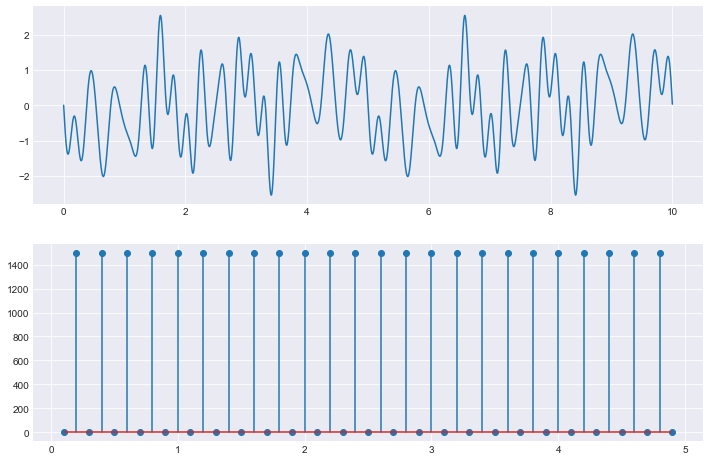

In [3]:
plt.close('all')

t = np.arange(0, 10, 0.001)
dt = 0.001
n = int(10/dt)

def multisine(frequencies):
    n = len(frequencies)
    seq = np.array(rudinshapiro(n) > 0).astype(float)
    print('length', n)
    print('frequencies', ', '.join(str(f) for f in frequencies))
    print('rs sequence', ', '.join(str(s) for s in seq))
    
    u = np.zeros(t.shape)
    amplitude = 0.3
    for f, s in zip(frequencies, seq):
        period = 1/f
        if (10/period).is_integer:
            print('{} periods for frequency {}'.format(10/period, f))
        u += amplitude*np.sin(2*np.pi*f*t + s*np.pi)
    return u

u_freq = np.arange(0.2, 5, 0.2)
u = multisine(u_freq)

x = np.fft.fft(u)
freq = np.fft.fftfreq(n, dt)
index = (freq > 0) & (freq < 5)

fig, ax = plt.subplots(2, 1)
ax[0].plot(t, u)
ax[1].stem(freq[index], np.abs(x[index]))
plt.show()

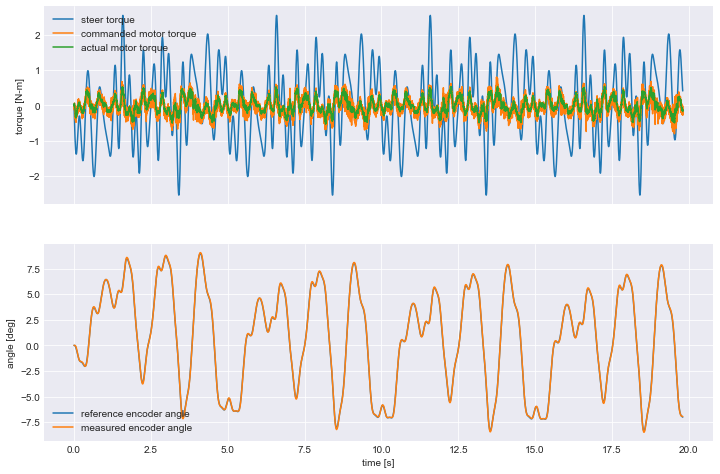

In [4]:
def plot_response(log):
    t = log.t
    u = log.records.input[:, 1] # steer torque
    w = ps.get_kollmorgen_command_torque(
            log.records.actuators.kollmorgen_command_velocity)
    r = log.states[:, 1] # reference steer angle
    y = log.measured_steer_angle
    
    fig, ax = plt.subplots(2, 1, sharex=True)
    ax[0].plot(t, u,
               label='steer torque')
    ax[0].plot(t, w,
               label='commanded motor torque')
    ax[0].plot(t, ps.get_kollmorgen_applied_torque(
                   log.records.sensors.kollmorgen_actual_torque),
               label='actual motor torque')
    ax[0].legend()
    ax[0].set_ylabel('torque [N-m]')
    
    ax[1].plot(t, r * 180/np.pi,
               label='reference encoder angle')
    ax[1].plot(t, y * 180/np.pi,
               label='measured encoder angle')
    ax[1].legend()
    ax[1].set_ylabel('angle [deg]')
    ax[1].set_xlabel('time [s]')
    return fig, ax

plt.close('all')
log = ps.ProcessedRecord('logs/multisine.pb.cobs.gz')
plot_response(log)
plt.show()

In [5]:
def frequency_response(input_signal, output_signal, last_n=None):
    if last_n is not None:
        assert last_n > 0
        last_n = -last_n
        
    index = slice(last_n, None)
    U = np.fft.fft(input_signal[index])
    Y = np.fft.fft(output_signal[index])
    
    Suu = U*np.conj(U)
    Syu = Y*np.conj(U)
    return Syu/Suu

# C = np.power(np.abs(Syu), 2)/(Suu * Syy) # coherence

In [6]:
# simulate model response to multisine 'u'
_, A, B = benchmark_state_space_vs_speed(*benchmark_matrices(), [5])
A = A[0]
B = B[0]
Bi = B[:, [1]] # steer torque
Ci = np.array([[1, 0, 0, 0]])
D = np.array([[0]])

sys = scipy.signal.StateSpace(A, Bi, Ci, D)
tf = scipy.signal.TransferFunction(sys)

# simulate for 20 seconds
lsim_t = np.arange(0, 20, dt)
lsim_u = np.concatenate((u, u))
_, lsim_y, lsim_x = scipy.signal.lsim(sys, lsim_u, lsim_t)

/Users/oliver/miniconda3/envs/dev/lib/python3.5/site-packages/scipy/signal/filter_design.py:1452: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


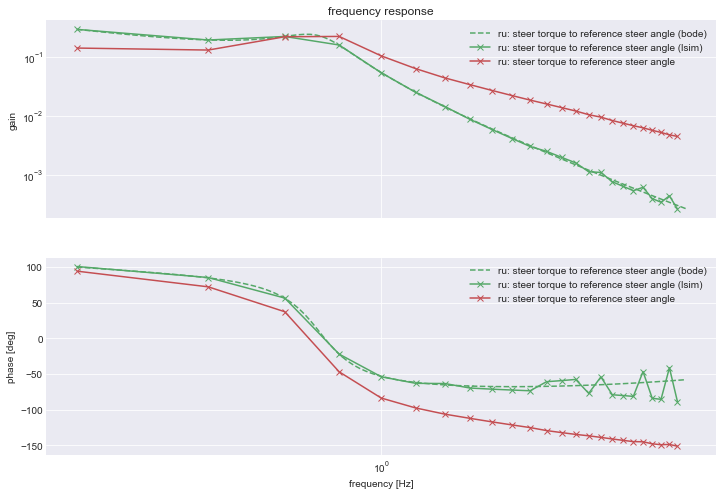

In [7]:
plot_all = False

log_u = log.records.input[:, 1] # steer torque
log_r = log.states[:, 1] # reference steer angle
log_y = log.measured_steer_angle[:]

n = int(10/dt) # use last 10 seconds of record
H = frequency_response(log_u, log_y, n)
G = frequency_response(log_u, log_r, n)
F = frequency_response(log_r, log_y, n)
X = frequency_response(lsim_u, lsim_y, n) # simulated model response

index = [i for i, f in enumerate(np.around(freq, 1))
         if f in np.around(u_freq, 1)]

plt.close('all')

# generate frequency response of previously defined model
w, mag, phase = tf.bode(w=2*np.pi*np.logspace(-0.7, 0.7, 100))
color = sns.color_palette('deep', 6)

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].loglog(w/2/np.pi, np.power(10, mag/20),
             linestyle='--', color=color[1],
             label='ru: steer torque to reference steer angle (bode)')
ax[0].loglog(freq[index], np.abs(X[index]),
             marker='x', color=color[1],
             label='ru: steer torque to reference steer angle (lsim)')
ax[0].loglog(freq[index], np.abs(G[index]),
             marker='x', color=color[2],
             label='ru: steer torque to reference steer angle')
if plot_all:
    ax[0].loglog(freq[index], np.abs(H[index]),
                 marker='x', color=color[0],
                 label='yu: steer torque to measured steer angle')
    ax[0].loglog(freq[index], np.abs(F[index]),
                 marker='x', color=color[3],
                 label='yr: reference to measured steer angle')
ax[0].legend()
ax[0].set_ylabel('gain')

ax[1].semilogx(w/2/np.pi, phase,
               linestyle='--', color=color[1],
               label='ru: steer torque to reference steer angle (bode)')
ax[1].semilogx(freq[index], np.angle(X[index], deg=True),
               marker='x', color=color[1],
               label='ru: steer torque to reference steer angle (lsim)')
ax[1].semilogx(freq[index], np.angle(G[index], deg=True),
               marker='x', color=color[2],
               label='ru: steer torque to reference steer angle')
if plot_all:
    ax[1].semilogx(freq[index], np.angle(H[index], deg=True),
                   marker='x', color=color[0],
                   label='yu: steer torque to measured steer angle')
    ax[1].semilogx(freq[index], np.angle(F[index], deg=True),
                   marker='x', color=color[3],
                   label='yr: reference to measured steer angle')
ax[1].legend()
ax[1].set_ylabel('phase [deg]')
               
ax[1].set_xlabel('frequency [Hz]')
ax[0].set_title('frequency response')

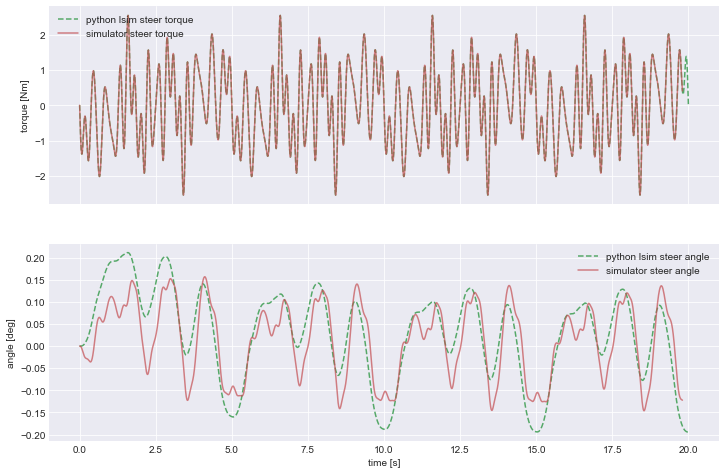

In [8]:
plt.close('all')
fig, ax = plt.subplots(2, 1, sharex=True)

ax[0].plot(lsim_t, lsim_u,
           color=color[1],
           linestyle='--',
           label='python lsim steer torque')
ax[0].plot(log.t, log_u,
           color=color[2],
           alpha=0.7,
           label='simulator steer torque')
ax[0].set_ylabel('torque [Nm]')
ax[0].legend()

ax[1].plot(lsim_t, lsim_y,
           color=color[1],
           linestyle='--',
           label='python lsim steer angle')
ax[1].plot(log.t, log_r,
           color=color[2],
           alpha=0.7,
           label='simulator steer angle')
ax[1].set_ylabel('angle [deg]')
ax[1].legend()

ax[1].set_xlabel('time [s]')

plt.show()